<a href="https://colab.research.google.com/github/Leorasaharia/CGM/blob/main/IDS_using_ANN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Dataset loaded. Memory usage: 439.03567600250244 MB

Using 30 most important features
Sequence shape: (1826599, 10, 30)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Epoch 5: 100%|██████████| 2855/2855 [00:34<00:00, 82.08batch/s, acc=0.858, loss=0.0447]


Epoch 5 | Train Acc: 0.8580 | Val Acc: 0.9049 | LR: 0.001000


Epoch 10: 100%|██████████| 2855/2855 [00:34<00:00, 81.89batch/s, acc=0.911, loss=0.0142]


Epoch 10 | Train Acc: 0.9110 | Val Acc: 0.9340 | LR: 0.001000


Epoch 15: 100%|██████████| 2855/2855 [00:33<00:00, 84.31batch/s, acc=0.928, loss=0.0327]


Epoch 15 | Train Acc: 0.9284 | Val Acc: 0.9418 | LR: 0.000500


Epoch 20: 100%|██████████| 2855/2855 [00:33<00:00, 84.02batch/s, acc=0.931, loss=0.113]


Epoch 20 | Train Acc: 0.9306 | Val Acc: 0.9439 | LR: 0.000500


Epoch 25: 100%|██████████| 2855/2855 [00:35<00:00, 80.48batch/s, acc=0.932, loss=0.0158]


Epoch 25 | Train Acc: 0.9325 | Val Acc: 0.9448 | LR: 0.000500


Epoch 30: 100%|██████████| 2855/2855 [00:35<00:00, 81.07batch/s, acc=0.937, loss=0.0343]


Epoch 30 | Train Acc: 0.9371 | Val Acc: 0.9465 | LR: 0.000250


Epoch 35: 100%|██████████| 2855/2855 [00:35<00:00, 80.39batch/s, acc=0.938, loss=0.0708]


Epoch 35 | Train Acc: 0.9379 | Val Acc: 0.9502 | LR: 0.000250


Epoch 40: 100%|██████████| 2855/2855 [00:34<00:00, 81.93batch/s, acc=0.941, loss=0.00359]


Epoch 40 | Train Acc: 0.9409 | Val Acc: 0.9519 | LR: 0.000125


Epoch 41: 100%|██████████| 2855/2855 [00:34<00:00, 82.50batch/s, acc=0.941, loss=0.0302]


Early stopping at epoch 41

🏆 Best Validation Accuracy: 0.9524


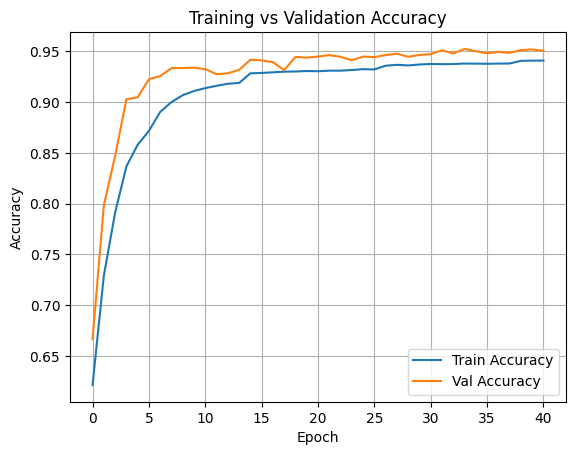

Model saved to: /content/drive/MyDrive/models/best_ann_lstm_model_final.pth

📊 ANN-LSTM Classification Report:
                         precision    recall  f1-score   support

           ARP_Spoofing       0.61      0.99      0.76      3239
                 Benign       1.00      0.94      0.97     38607
MQTT-DDoS-Connect_Flood       1.00      1.00      1.00     34458
MQTT-DDoS-Publish_Flood       1.00      1.00      1.00      5467
 MQTT-DoS-Connect_Flood       0.98      1.00      0.99      2511
 MQTT-DoS-Publish_Flood       1.00      1.00      1.00      8823
    MQTT-Malformed_Data       0.82      0.99      0.90      1005
          Recon-OS_Scan       0.51      0.92      0.65      3361
       Recon-Ping_Sweep       0.92      0.97      0.95       154
        Recon-Port_Scan       0.98      0.81      0.88     16950
          Recon-VulScan       0.38      0.78      0.51       421
       TCP_IP-DDoS-ICMP       1.00      1.00      1.00     38758
        TCP_IP-DDoS-SYN       1.00      1.0

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

# --- 1. Optimized Data Loading ---
def load_data(filepath):
    chunks = []
    for chunk in pd.read_csv(filepath, chunksize=10000):
        numeric_cols = chunk.select_dtypes(include=np.number).columns
        chunk[numeric_cols] = chunk[numeric_cols].astype(np.float32)
        if 'Label' in chunk.columns:
            chunk['Label'] = chunk['Label'].astype('category')
        chunks.append(chunk)
    return pd.concat(chunks, axis=0)

filepath = '/content/drive/MyDrive/DL summer intern project/merged_dataset_end.csv'

try:
    df = load_data(filepath)
    print("Dataset loaded. Memory usage:", df.memory_usage(deep=True).sum()/1024**2, "MB")
except Exception as e:
    print("Error loading dataset:", e)
    raise

# --- 2. Enhanced Feature Selection ---
target = 'Label'
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
if target in numeric_features:
    numeric_features.remove(target)

selector = VarianceThreshold(0.01)
X = selector.fit_transform(df[numeric_features])
features = [numeric_features[i] for i in selector.get_support(indices=True)]
print(f"\nUsing {len(features)} most important features")

# --- 3. LSTM-Specific Data Preprocessing ---
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

le = LabelEncoder()
y = le.fit_transform(df[target])

del df
gc.collect()

# --- 4. Sequence Creation for LSTM ---
def create_sequences(data, labels, sequence_length=10):
    sequences = []
    seq_labels = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
        seq_labels.append(labels[i + sequence_length - 1])
    return np.array(sequences), np.array(seq_labels)

sequence_length = 10
X_seq, y_seq = create_sequences(X, y, sequence_length)
print(f"Sequence shape: {X_seq.shape}")

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True)

batch_size = 512
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# --- 6. ANN-LSTM Hybrid Model Architecture ---
class ANN_LSTM_IDS(nn.Module):
    def __init__(self, input_size, num_classes, hidden_dim=64, num_layers=1):
        super(ANN_LSTM_IDS, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.dropout_post_lstm = nn.Dropout(0.3)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, features = x.size()
        x_reshaped = x.view(-1, features)
        features_extracted = self.feature_extractor(x_reshaped)
        features_extracted = features_extracted.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(features_extracted)
        lstm_out = self.dropout_post_lstm(lstm_out)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        final_features = attn_out[:, -1, :]
        output = self.classifier(final_features)
        return output

# --- 7. Enhanced Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN_LSTM_IDS(X_train.shape[2], len(le.classes_)).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(
    alpha=1,
    gamma=2,
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.02)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# --- 8. Advanced Training Loop with Accuracy Plot ---
def train_model(epochs):
    best_acc = 0
    patience_counter = 0
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch}") as tepoch:
            for batch_x, batch_y in tepoch:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()
                tepoch.set_postfix(loss=loss.item(), acc=train_correct/train_total)

        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_ann_lstm_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 5 == 0:
            print(f'Epoch {epoch} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if patience_counter >= 7:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"\n🏆 Best Validation Accuracy: {best_acc:.4f}")

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 9. Start Training ---
train_model(100)

# --- 10. Final Evaluation ---
model_save_path = '/content/drive/MyDrive/models/best_ann_lstm_model_final.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to: {model_save_path}')

model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("\n📊 ANN-LSTM Classification Report:")
print(classification_report(all_targets, all_preds, target_names=le.classes_))

confidence_scores = np.max(all_probs, axis=1)
print(f"\n📈 Average Prediction Confidence: {np.mean(confidence_scores):.4f}")


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
filepath = '/content/drive/MyDrive/DL summer intern project/merged_dataset_end.csv'
df = pd.read_csv(filepath)

# Display label counts
print(df['Label'].value_counts())


Label
TCP_IP-DDoS-UDP            206170
TCP_IP-DDoS-TCP            202311
TCP_IP-DDoS-SYN            199390
TCP_IP-DDoS-ICMP           194938
Benign                     192732
MQTT-DDoS-Connect_Flood    173036
TCP_IP-DoS-UDP             137011
TCP_IP-DoS-SYN             111431
TCP_IP-DoS-ICMP            104507
TCP_IP-DoS-TCP              95407
Recon-Port_Scan             83981
MQTT-DoS-Publish_Flood      44376
MQTT-DDoS-Publish_Flood     27623
Recon-OS_Scan               16832
ARP_Spoofing                16047
MQTT-DoS-Connect_Flood      12773
MQTT-Malformed_Data          5130
Recon-VulScan                2173
Recon-Ping_Sweep              740
Name: count, dtype: int64


/tmp/ipython-input-572225137.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Main_Class', order=df['Main_Class'].value_counts().index, palette='Set2')


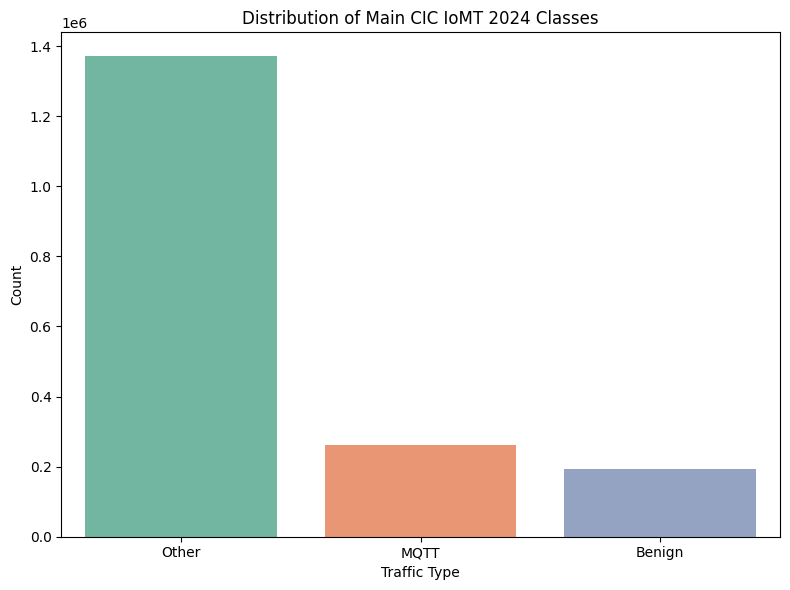

In [ ]:
# Combine MQTT-related and benign
df['Main_Class'] = df['Label'].apply(lambda x: 'Benign' if 'Benign' in x
                                     else ('MQTT' if 'MQTT' in x else 'Other'))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Main_Class', order=df['Main_Class'].value_counts().index, palette='Set2')
plt.title("Distribution of Main CIC IoMT 2024 Classes")
plt.ylabel("Count")
plt.xlabel("Traffic Type")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2727159686.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_labels.index, y=top_labels.values, palette='viridis')


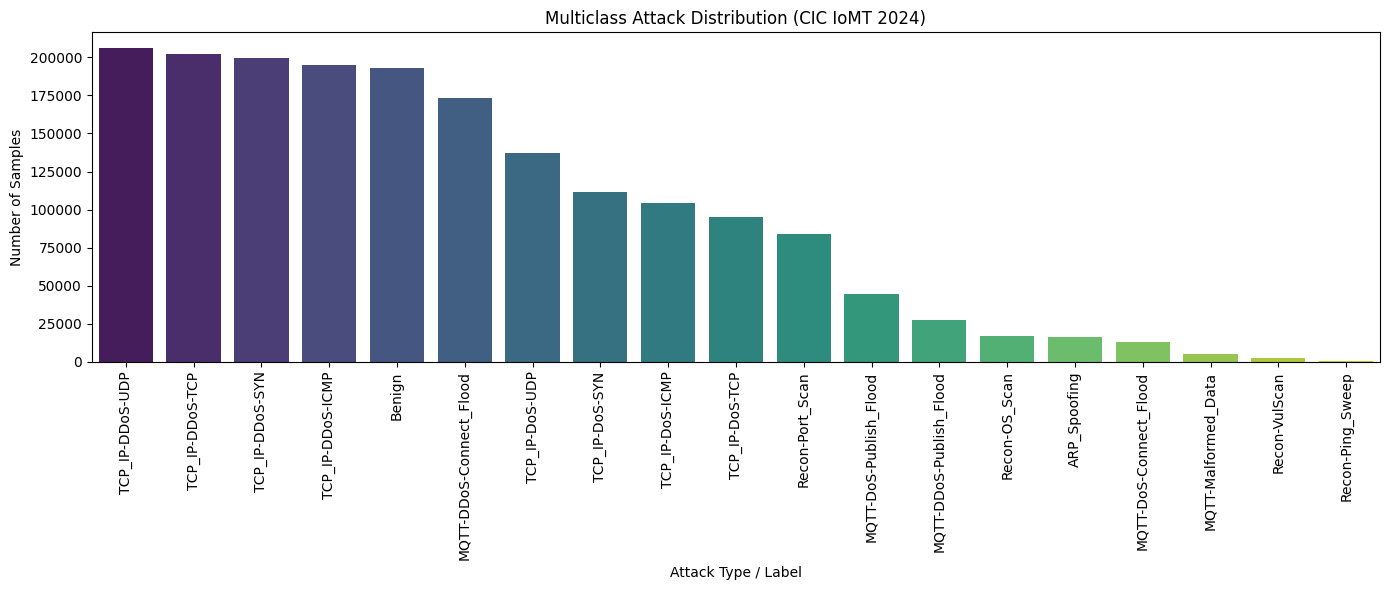

In [ ]:
plt.figure(figsize=(14, 6))
top_labels = df['Label'].value_counts()
sns.barplot(x=top_labels.index, y=top_labels.values, palette='viridis')
plt.title("Multiclass Attack Distribution (CIC IoMT 2024)")
plt.xticks(rotation=90)
plt.ylabel("Number of Samples")
plt.xlabel("Attack Type / Label")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2722795709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dos_ddos['DoS_Type'] = df_dos_ddos['Label'].apply(lambda x: 'DDoS' if 'DDoS' in x else 'DoS')
/tmp/ipython-input-2722795709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_dos_ddos, x='DoS_Type', palette='pastel')


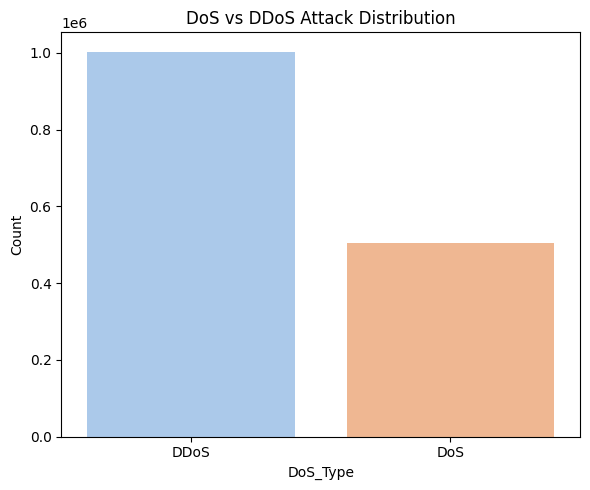

In [ ]:
# Filter only DoS and DDoS labels
df_dos_ddos = df[df['Label'].str.contains("DoS|DDoS", case=False)]

# High-level category
df_dos_ddos['DoS_Type'] = df_dos_ddos['Label'].apply(lambda x: 'DDoS' if 'DDoS' in x else 'DoS')

plt.figure(figsize=(6, 5))
sns.countplot(data=df_dos_ddos, x='DoS_Type', palette='pastel')
plt.title("DoS vs DDoS Attack Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


/tmp/ipython-input-965337704.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subclass_counts.index, y=subclass_counts.values, palette='rocket')


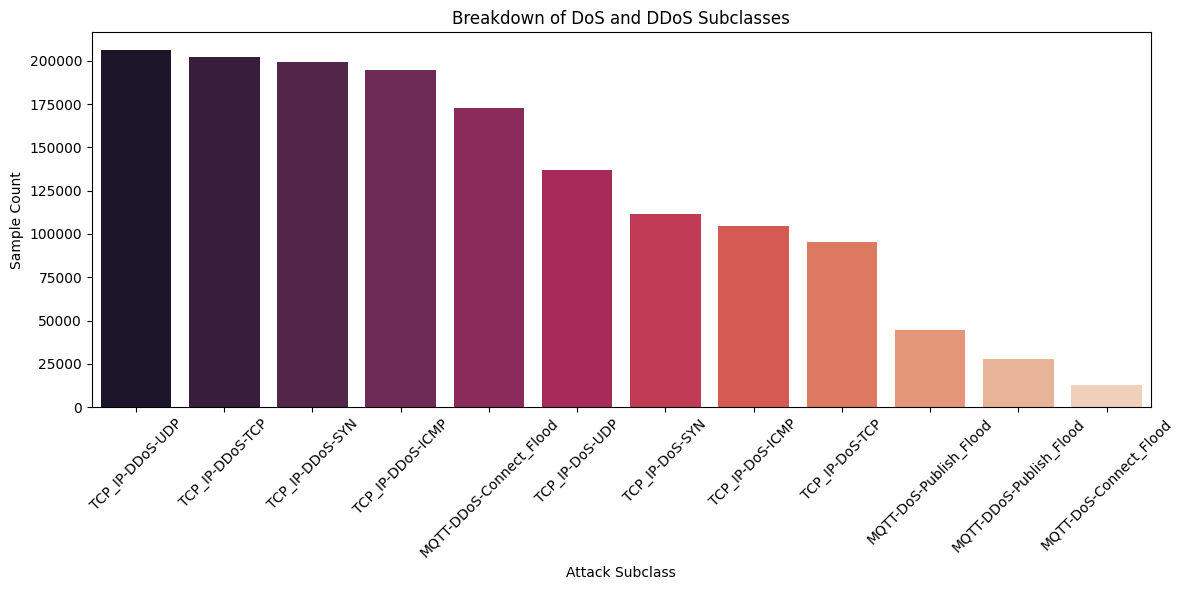

In [ ]:
plt.figure(figsize=(12, 6))
subclass_counts = df_dos_ddos['Label'].value_counts()
sns.barplot(x=subclass_counts.index, y=subclass_counts.values, palette='rocket')
plt.title("Breakdown of DoS and DDoS Subclasses")
plt.xticks(rotation=45)
plt.ylabel("Sample Count")
plt.xlabel("Attack Subclass")
plt.tight_layout()
plt.show()


In [ ]:
all_preds = []
all_probs = []

with torch.no_grad():
    for batch_x, _ in test_loader_unseen:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert predictions back to labels
predicted_labels = le.inverse_transform(all_preds)

# Average confidence
confidence_scores = np.max(all_probs, axis=1)
print(f"\n📈 Average Confidence on Unseen Data: {np.mean(confidence_scores):.4f}")


NameError: name 'torch' is not defined

In [ ]:
X_test_raw = test_df[features].astype(np.float32)


In [ ]:
features = [numeric_features[i] for i in selector.get_support(indices=True)]


In [ ]:
X_test_scaled = scaler.transform(X_test_raw)


NameError: name 'scaler' is not defined

In [ ]:
y_test_encoded = le.transform(test_df['Label'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1024056086.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Label', data=df_labels, order=df_labels['Label'].value_counts().index, palette='viridis')


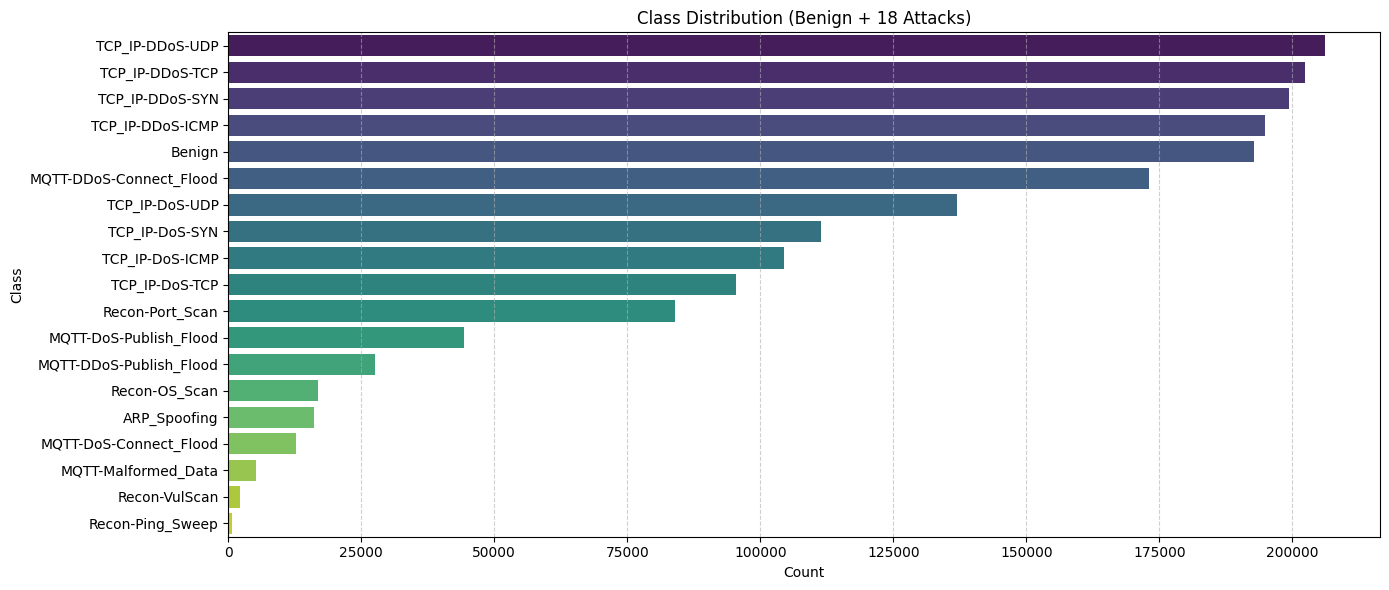

In [ ]:
# Mount Google Drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
filepath = '/content/drive/MyDrive/DL summer intern project/merged_dataset_end.csv'
df_labels = pd.read_csv(filepath)


# Plot class distribution
plt.figure(figsize=(14, 6))
sns.countplot(y='Label', data=df_labels, order=df_labels['Label'].value_counts().index, palette='viridis')
plt.title('Class Distribution (Benign + 18 Attacks)')
plt.xlabel('Count')
plt.ylabel('Class')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


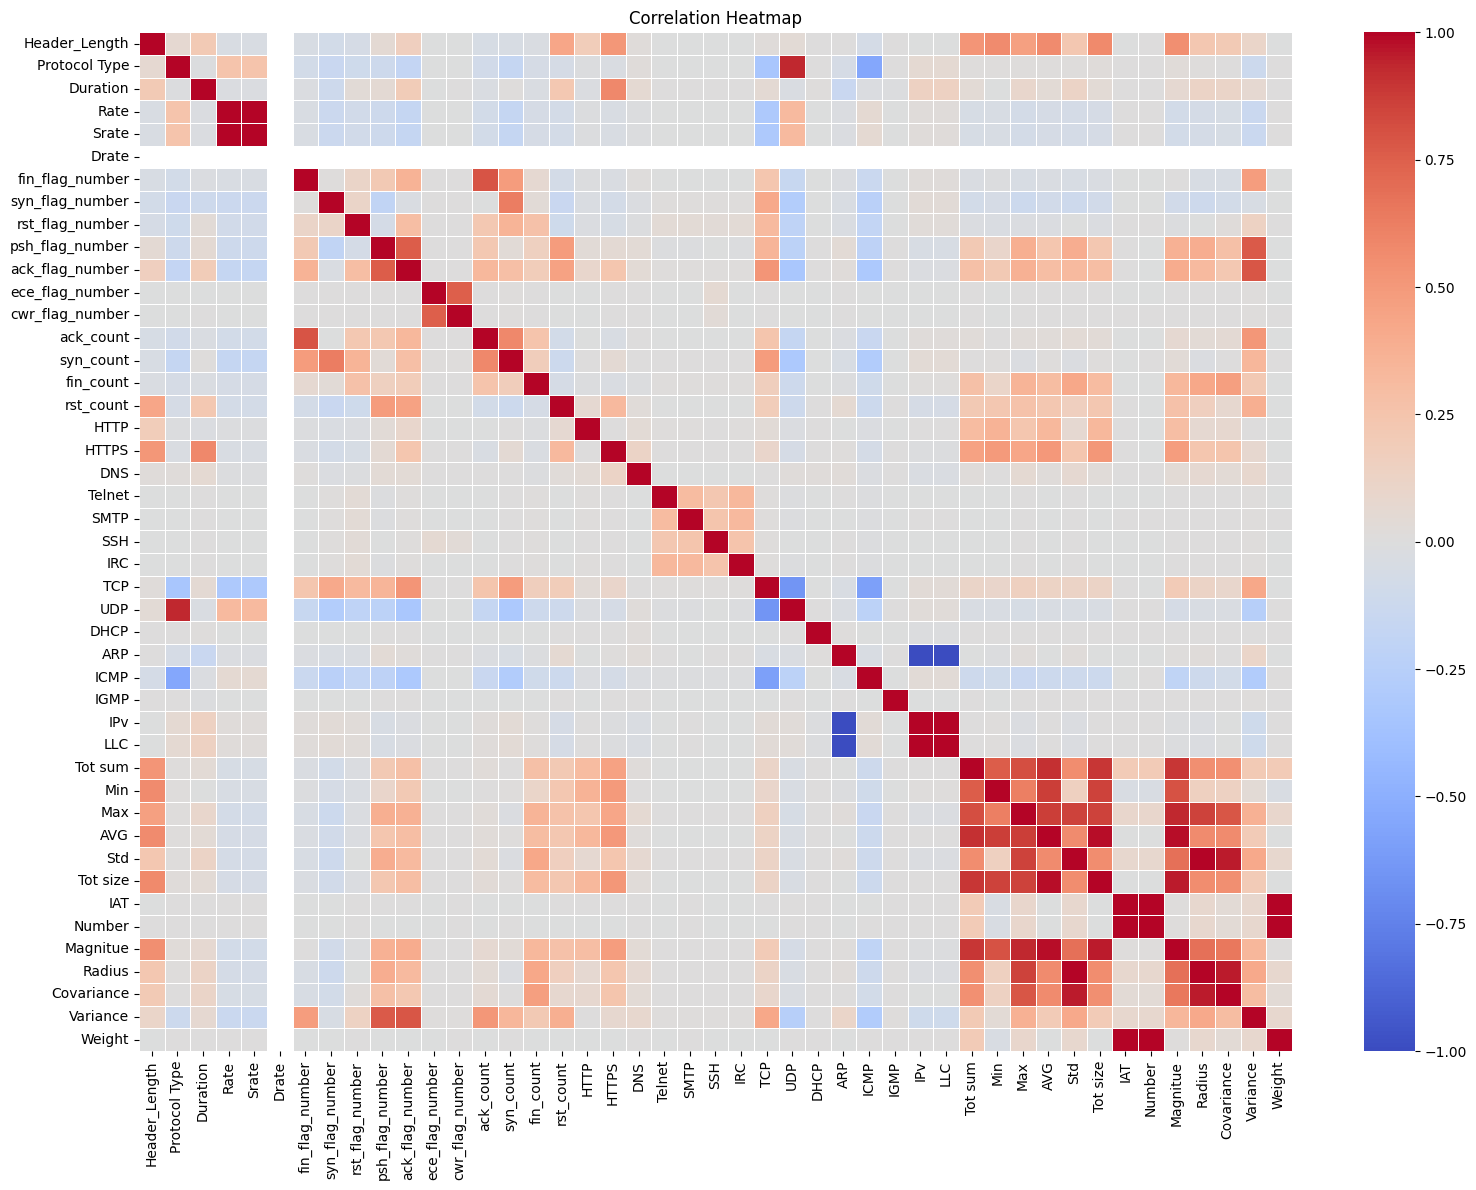

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
filepath = '/content/drive/MyDrive/DL summer intern project/merged_dataset_end.csv'
df = pd.read_csv(filepath)

# Optional: drop non-numeric columns (like labels or IPs) before correlation
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()
